import clasic libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from matplotlib import colors


import python scripts and imporlib

In [3]:
import importlib
import src  # python scripts

import files, functions, classes

In [4]:
from src.UpscaleMatrix import upscale_matrix
#from py_scripts.TissueIrradiationProblem import TissueIrradiationProblem
#from py_scripts.TissueIrradiationOptimizer import TissueIrradiationOptimizer
from src import TissueIrradiationProblem, TissueIrradiationOptimizer


## Import SITCF coefficients
 - SITCF - Simulated Irradiation Tissue Cells Factors
 * I use shoret abbrv: **SIF = Simulation Irradiation Factors**
 - simulation based dose distribution
 - I import those later in code - here i can use coeffs to plot distributions from simulation

In [187]:
# import SIF coeffs matrix from simulation
beam_type_idx = 0
beam_spectrum_type = ["mono", "rtg"][beam_type_idx]  # choose one of the two spectrum types
tissue_length = 15  # cm
num_pixels = 3  # number of pixels in each direction
Ebeam = [100, 6][beam_type_idx]  # photon energy in keV
Eunit = ["kev","MV"][beam_type_idx]
Ebeam_txt = f"{Ebeam}{Eunit}"
Nsim = "1e+03"

fp = f"../../SIF_coefficients/SIF_{beam_spectrum_type}_{tissue_length}cm_{num_pixels}pixels_{Ebeam_txt}_{Nsim}photons.npy"

print(f"Filepath to SIF data: {fp}")
# load data from npy file
SIF_data = np.load(fp)

Filepath to SIF data: ../../SIF_coefficients/SIF_mono_15cm_3pixels_100kev_1e+03photons.npy


In [ ]:
# print(SIF_data[0])
# print()
# print(SIF_data[6])
# print()

# from src import BeamDataExpansion as BDE
# # correct expansion of SIF_data
# SIF_data = BDE.repair_wrong_expansion(SIF_data)

# print(SIF_data[0])
# print()
# print(SIF_data[6])

[[1.         0.50914638 0.20770375]
 [0.1375914  0.16121667 0.08373617]
 [0.04042525 0.06195055 0.03978992]]

[[0.04042525 0.1375914  1.        ]
 [0.06195055 0.16121667 0.50914638]
 [0.03978992 0.08373617 0.20770375]]

[[1.         0.50914638 0.20770375]
 [0.1375914  0.16121667 0.08373617]
 [0.04042525 0.06195055 0.03978992]]

[[0.04042525 0.1375914  1.        ]
 [0.06195055 0.16121667 0.50914638]
 [0.03978992 0.08373617 0.20770375]]


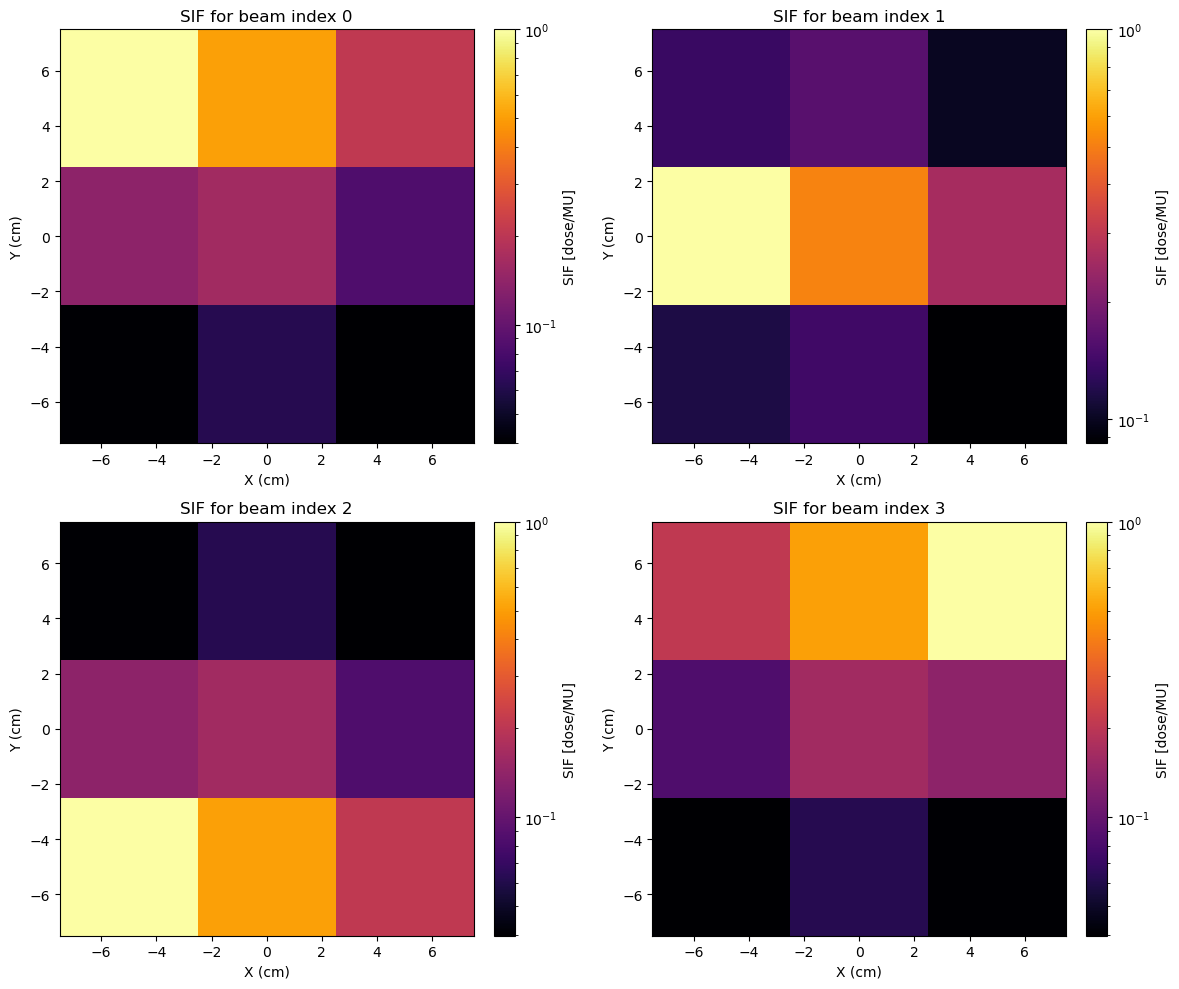

In [188]:
import matplotlib.colors as mcolors

a = tissue_length / 2
max_beam_idx = num_pixels // 2 

#fig, axes = plt.subplots(1, 4, figsize=(15, 8))
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    SIF_beam = SIF_data[i]
    im = ax.imshow(SIF_beam, origin='upper', cmap='inferno', extent=(-a, a, -a, a), norm=mcolors.LogNorm())
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f"SIF for beam index {i}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='SIF [dose/MU]')
plt.tight_layout()
plt.show()

---
---
# Optimize Irradiation plan

---
### 1. define Tissue Matrix
 - for now i work with square shape + odd number of cells in each direction

Plotting tissue matrix...


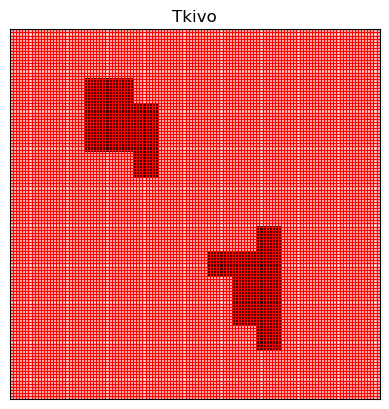

In [318]:
# test the class
tissue_matrix_3by3 = np.array([[0, 0, 0,],
                           [0, 1, 0],
                           [0,1,1]])

tissue_matrix_5by5 = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0],   
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 0, 0],
                           [0, 0, 0, 0, 0]])

tissue_matrix_7by7 = np.array([[0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0],
                               [0, 0, 1, 1, 1, 1, 0],
                               [0, 0, 0, 1, 1, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0]])

tissue_matrix_9by9 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 0, 0, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0, 0, 0],
                               [0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0, 0, 0],
                               [0, 0, 1, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0]])

tissue_matrix_11by11 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
                                 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## last boss: 15x15 pixels with 2 tumors
#tissue_matrix_15by15 = np.zeros((15, 15))
tissue_matrix_15by15 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

#* choose one of the matrices above
tissue_matrix = tissue_matrix_15by15

#* upscale matrix (optional, for testing lin. prog. capabilities...)
upscale_factor = 8
if upscale_factor > 1:
    tissue_matrix = upscale_matrix(tissue_matrix, upscale_factor)

importlib.reload(TissueIrradiationProblem)
# create a problem instance
problem = TissueIrradiationProblem.tissue_irradiation_problem(tissue_matrix)
#* plot the tissue matrix
# 1 = tumor = black
# 0 = healthy = white
problem.plot_tissue()


---
### 2. define optimization parameters

* dose constraints to tumor and optionally healthy cells


In [319]:
# dose constraints to tumor and optionally healthy cells
MinDoseTumor = 100  # minimum dose to tumor cells

MaxDoseHealthy = None # maximum dose to healthy cells (optional, can be None, can cause optimization issues!)

cell_dose_constr = {
    'min_dose_tumor': MinDoseTumor,
    'max_dose_healthy': MaxDoseHealthy
}

* mean free paths of photons - energy dependance

MAIN TAKEAWAYS:
	-Diagnostic beams (50-200keV) - mfp = 4-7cm
	-Therapeutic beams (1-10MeV) - mfp = 10-40cm


At 10.0 keV, total linear attenuation coefficient is 6.5882 /cm; (mean free path = 0.1518 cm)
At 20.0 keV, total linear attenuation coefficient is 0.9412 /cm; (mean free path = 1.0625 cm)
At 35.0 keV, total linear attenuation coefficient is 0.3388 /cm; (mean free path = 2.9517 cm)
At 25.0 keV, total linear attenuation coefficient is 0.6715 /cm; (mean free path = 1.4892 cm)
At 50.0 keV, total linear attenuation coefficient is 0.2303 /cm; (mean free path = 4.3426 cm)
At 80.0 keV, total linear attenuation coefficient is 0.1871 /cm; (mean free path = 5.3437 cm)
At 100.0 keV, total linear attenuation coefficient is 0.1751 /cm; (mean free path = 5.7106 cm)
At 250.0 keV, total linear attenuation coefficient is 0.1333 /cm; (mean free path = 7.5030 cm)
At 500.0 keV, total linear attenuation coefficient is 0.1015 /cm; (mean free path = 9.8537 cm)
At 1000.0 keV, total linear attenuation co

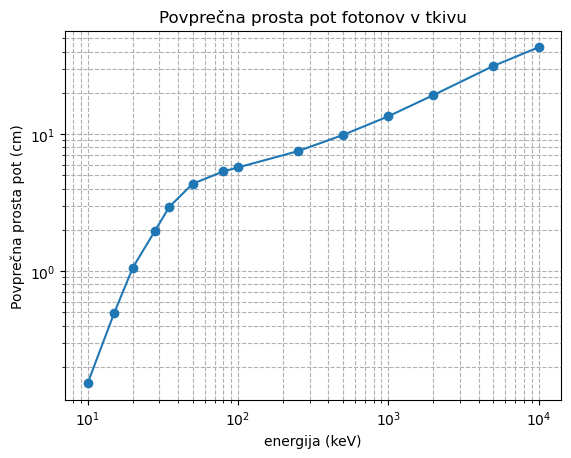

In [124]:
print("MAIN TAKEAWAYS:\n\t-Diagnostic beams (50-200keV) - mfp = 4-7cm\n\t-Therapeutic beams (1-10MeV) - mfp = 10-40cm\n\n")


from src import LinearAttenuationCoefficients as LACload
importlib.reload(LACload)
path = "../mac_nistxcom/mac_tissue.txt"
tissue_density = 1.06  # g/cm^3
tissue_lac_importer = LACload.LACLoader(path, tissue_density, material_name="mehko tkivo")

doPlot = 0
if doPlot:
    tissue_lac_importer.plot()

energies = [0.01,0.02,0.035,0.025,0.05,0.08,0.1,0.25,0.5,1.0,2,5,10] # MeV
#energies = [0.01,0.0125,0.015,0.0175,0.02,0.024,0.028,0.035,0.042,0.05,0.08,0.1,0.25,0.5,1.0,2,5,10] # MeV


for energy in energies:
    lac_value = tissue_lac_importer.get_lac_at_energy(energy)
    print(f"At {energy*1000} keV, total linear attenuation coefficient is {lac_value:.4f} /cm"
          f"; (mean free path = {1/lac_value:.4f} cm)"
          )


###!!!! ADD THIS TO CLASS DEFINITION !!!!####
# make a plot - LAC(energy) or MFP(energy) [mean free path]
#energy_pts = np.array([0.01, 0.025,0.05,0.1,0.25,0.5, 0.8,1.0,2.5,5]) 
energy_pts = np.array([0.01,0.015,0.02,0.028,0.035,0.05,0.08,0.1,0.25,0.5,1.0,2,5,10]) # MeV

lac_pts = np.array([tissue_lac_importer.get_lac_at_energy(energy) for energy in energy_pts])
mfp_pts = 1/lac_pts
#plt.plot(energy_pts, lac_pts, marker='o', label='LAC')
plt.plot(energy_pts*1000, mfp_pts, marker='o', label='MFP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energija (keV)')
#plt.ylabel('Linear Attenuation Coefficient (/cm)')
plt.ylabel('Povprečna prosta pot (cm)')
#plt.title('Linear Attenuation Coefficient vs Energy for Tissue')
plt.title('Povprečna prosta pot fotonov v tkivu')
plt.grid(True, which="both", ls="--")

* define beam type

In [311]:
 #* choose beam type: 'constant', 'exponential', or 'simulated'
beam_type = ['constant','exponential','simulated'][1]  

print(f"---------------Beam type chosen: {beam_type}-------------------")



---------------Beam type chosen: exponential-------------------


* parameters of exponential and simulated beams
    - exponential - mean free path
    - simulation - tissue length, num of pixels, beam type and energy, Nsim, SIF_data 

In [320]:
 
#$ exponential ...
# mfp in terms of cells, eg 2 cells, multiply by uscale_factor if supcaled matrix
#! shall approximately match real data! (use LACloader and calculated mean free paths!)
#!  -> compare to simulated beam type optimization
mean_free_path = 10 * upscale_factor
lac = 1.0 / mean_free_path  # linear attenuation coefficient in 1/cell

#$ handle simulated SITCF factors and mean free path ...
beam_idx = 1
beam_spectrum_type = ["mono", "rtg"][beam_idx]  # choose one of the two spectrum types
tissue_length = 25  # cm
num_pixels = 15  # number of pixels in each direction
Ebeam = [150, 6][beam_idx]  # photon energy in keV
Eunit = ["kev","MV"][beam_idx]
Ebeam_txt = f"{Ebeam}{Eunit}"
Nsim = "2e+04"

fp = f"../../SIF_coefficients/SIF_{beam_spectrum_type}_{tissue_length}cm_{num_pixels}pixels_{Ebeam_txt}_{Nsim}photons.npy"
print(f"Filepath to SIF data: {fp}")
SIF_data = np.load(fp)

# if not simulated beam, set SIF to None (default)
if beam_type != 'simulated':
    SIF_data = None

# for simulated beam tissue shape must be correct (meet criteria)
if beam_type == 'simulated':
    # number of rows/columns in the simulated tissue matrix
    tissue_dimension_simulated = SIF_data.shape[0] // 4  
    if tissue_dimension_simulated == tissue_matrix.shape[0]:
        print("Tissue shape for 'simulated' beam type is correct.")
    else:
        raise ValueError("Tissue shape for 'simulated' beam type should be" \
                          f"{tissue_dimension_simulated}x{tissue_dimension_simulated}; " \
                          f"but got {tissue_matrix.shape[0]}x{tissue_matrix.shape[1]}.")



Filepath to SIF data: ../../SIF_coefficients/SIF_rtg_25cm_15pixels_6MV_2e+04photons.npy


In [321]:
# prepare data for linear programming
ProblemParameters = problem.prepare_data_for_linprog(
    cell_dose_constr,
    beam_type=beam_type, 
    lac=lac, 
    sim_irr_factors=SIF_data
    )

#ProblemParameters


Using exponential intensity beam model with linear attenuation coefficient (lac): 0.0125 /cm
Linear programming inputs defined.


optimization time

In [322]:
# optimize class
importlib.reload(TissueIrradiationOptimizer)
optimizer = TissueIrradiationOptimizer.tissue_irradiation_optimizer(ProblemParameters)
# run optimization
report = [False, True] [1]
optimizer.optimize(doReport=report)

# calculate dose distribution
TissueDoseDistribution = optimizer.tissue_dose_matrix

#print(f"\nDose Distribution Matrix:\n{TissueDoseDistribution}")



Optimization successful.
Optimal value: 363628.5783300309
Optimal solution: [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   1.67682154   3.35390509   5.03151269   6.70990648   8.3893487
  10.07010178  11.75242833  13.43659122  15.1228536   16.81147897
  18.50273116  20.19687443  21.89417352  23.59489361  25.29930045
   0.           0.           2.04807446   4.09646893   6.17191724
   8.24832993  10.32603144  12.40534642   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.     

plot and statistics

Plotting tissue matrix...


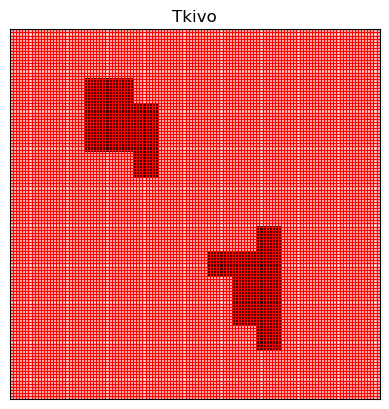

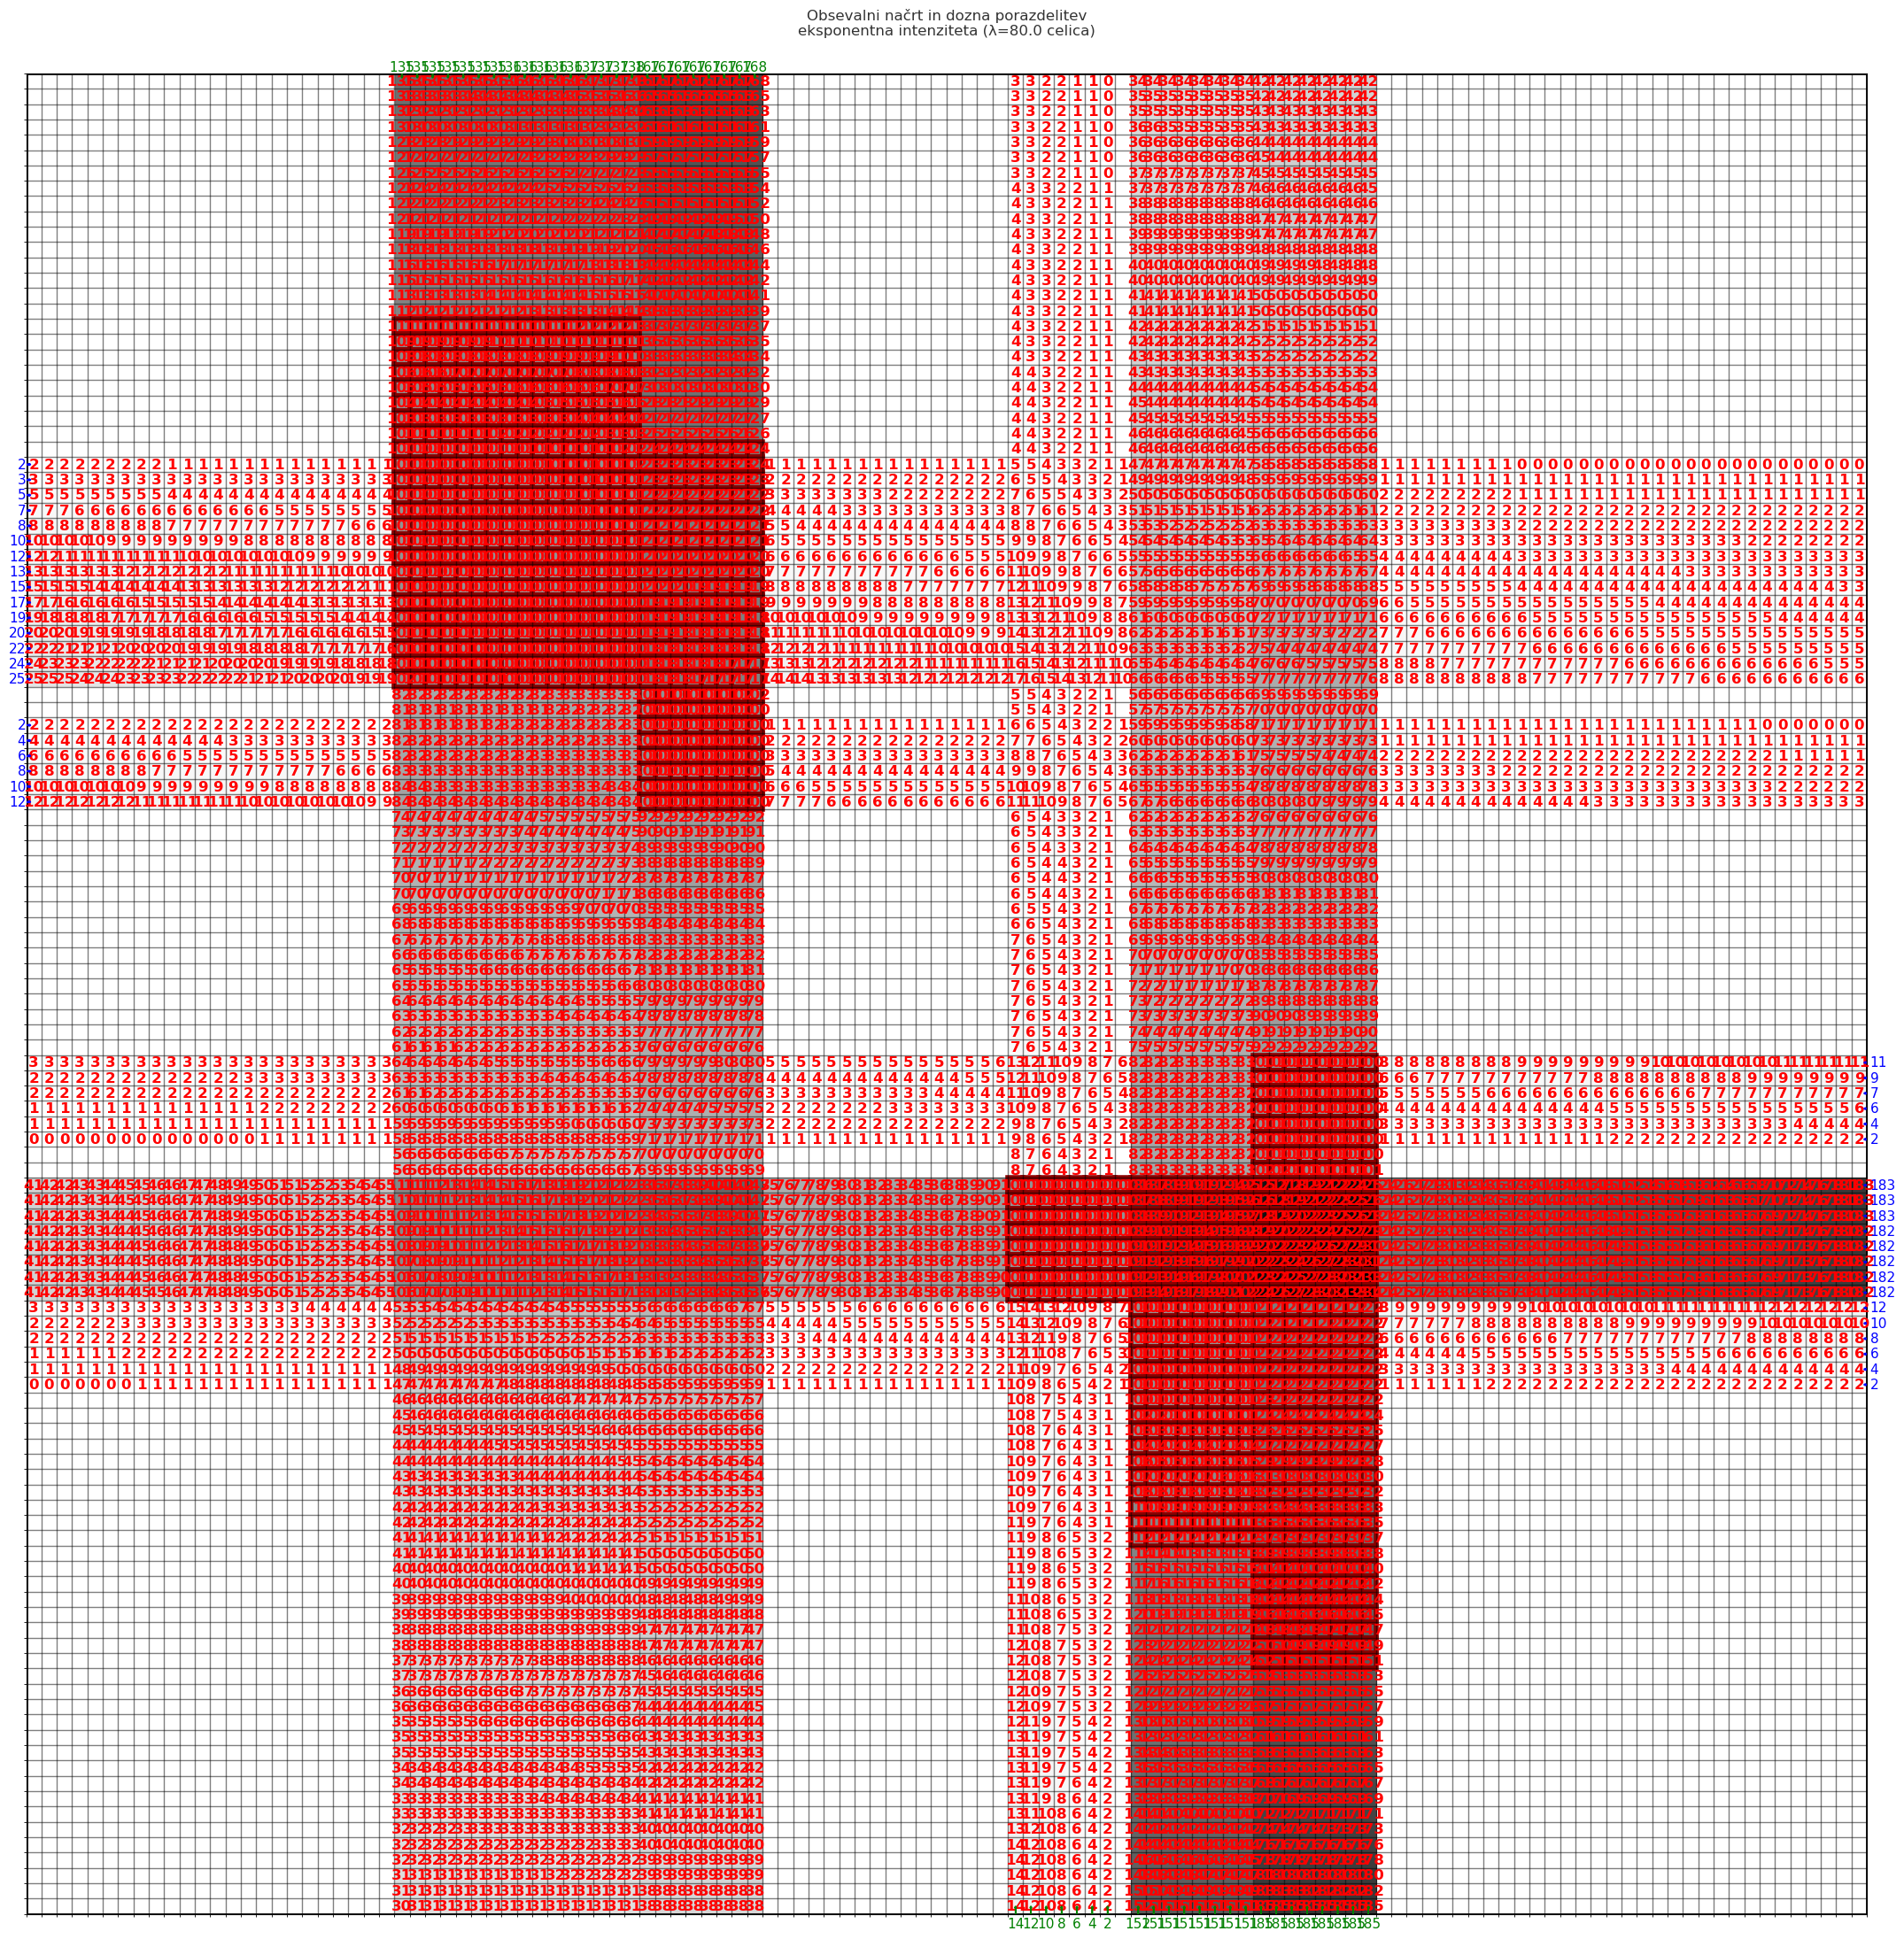

Statistics:
Average dose to tumor cells: 121.08
Average dose to healthy cells: 27.45
Ratio (tumor:healthy) = 4.41


In [323]:
problem.plot_tissue()
#optimizer.plot_dose_distribution()
optimizer.plot_irradiation_scheme()
# calculate statistics
optimizer.report_statistics()

----------

## Testing D_healthy_mean as func for DoseHealthyMax

In [278]:
# dose constraints to tumor and optionally healthy cells
MinDoseTumor = 100  # minimum dose to tumor cells
MaxDoseHealthy = None # maximum dose to healthy cells (optional, can be None, can cause optimization issues!)
cell_dose_constr = {
    'min_dose_tumor': MinDoseTumor,
    'max_dose_healthy': MaxDoseHealthy
}

# prepare data for linear programming
ProblemParameters = problem.prepare_data_for_linprog(
    cell_dose_constr,
    beam_type=beam_type, 
    lac=lac, 
    sim_irr_factors=SIF_data
    )

optimizer = TissueIrradiationOptimizer.tissue_irradiation_optimizer(ProblemParameters)
# run optimization
optimizer.optimize()
# calculate dose distribution
TissueDoseDistribution = optimizer.tissue_dose_matrix

# plot
#problem.plot_tissue()
#optimizer.plot_dose_distribution()
#optimizer.plot_irradiation_scheme()
# calculate statistics
optimizer.report_statistics()
print("\tEnd of optimization\n")

Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.
Statistics:
Average dose to tumor cells: 121.97
Average dose to healthy cells: 34.49
Ratio (tumor:healthy) = 3.54
	End of optimization



--- Now testing Dmax_healthy = 92 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


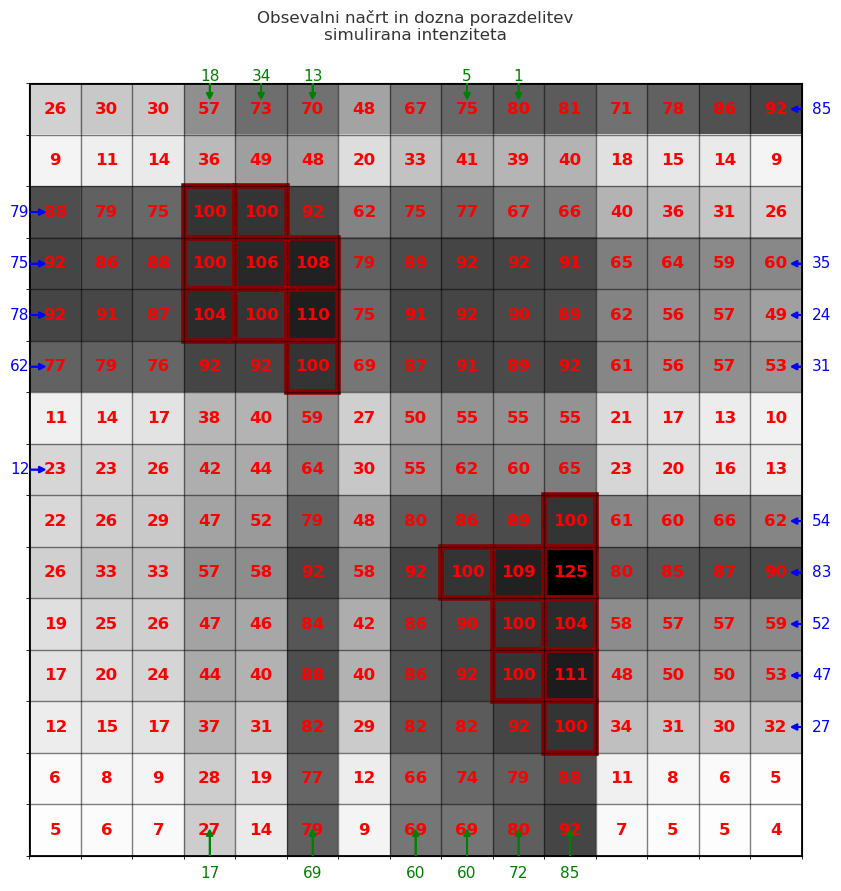

Statistics:
Average dose to tumor cells: 104.26
Average dose to healthy cells: 51.72
Ratio (tumor:healthy) = 2.02
Average dose to healthy tissue: 51.72
	End of optimization

--- Now testing Dmax_healthy = 95 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


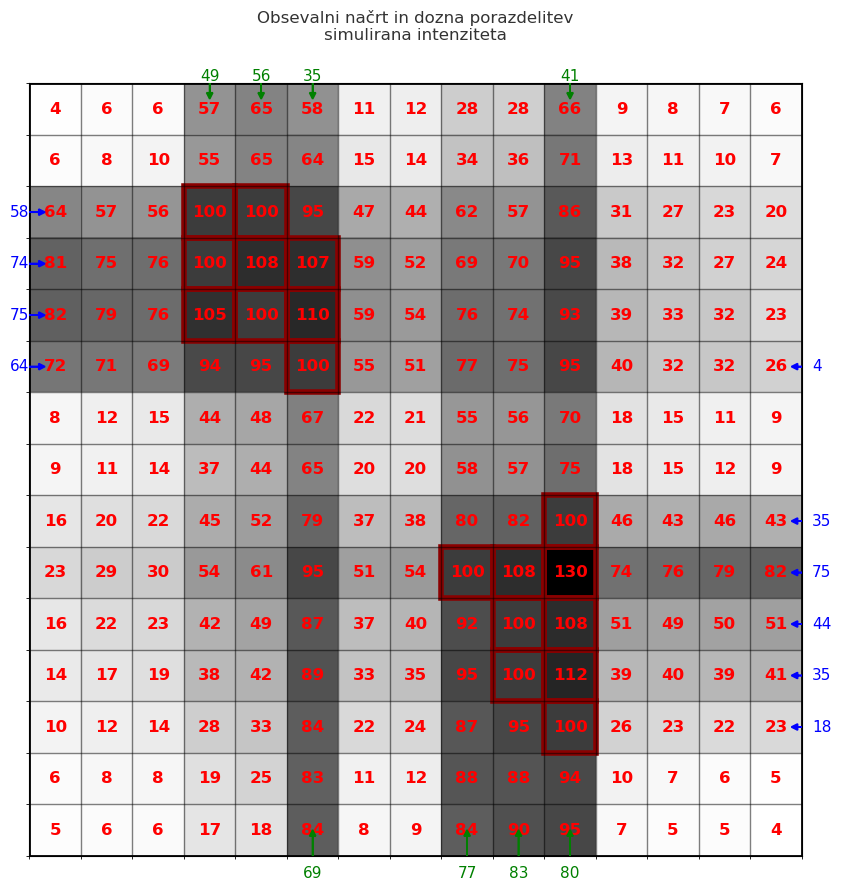

Statistics:
Average dose to tumor cells: 104.88
Average dose to healthy cells: 41.62
Ratio (tumor:healthy) = 2.52
Average dose to healthy tissue: 41.62
	End of optimization

--- Now testing Dmax_healthy = 98 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


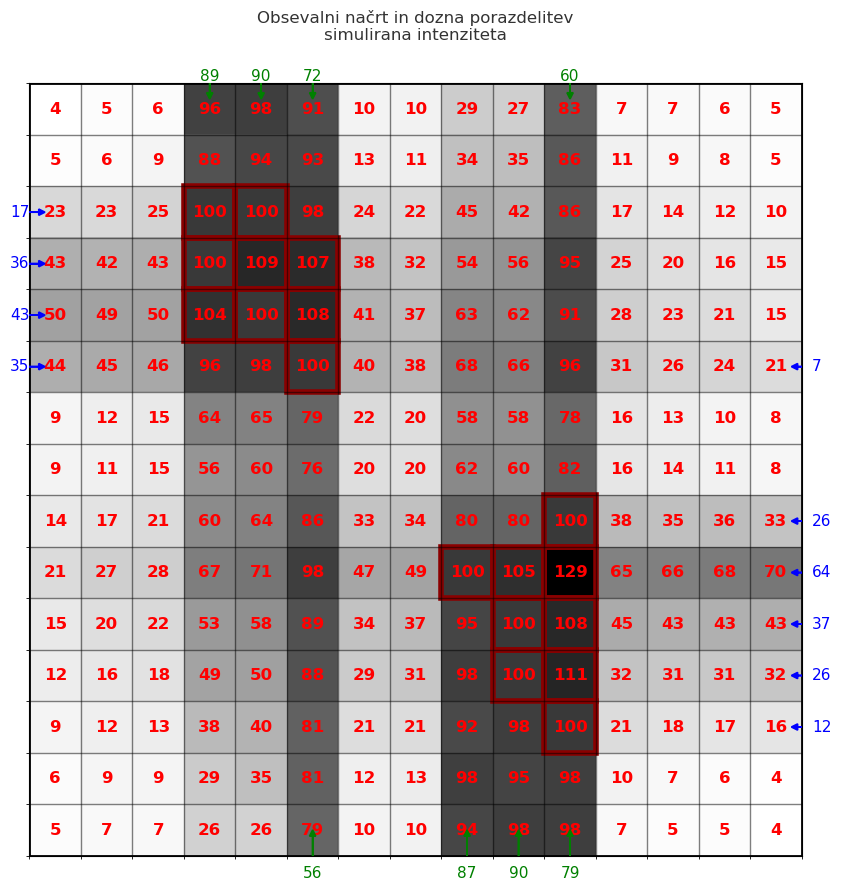

Statistics:
Average dose to tumor cells: 104.57
Average dose to healthy cells: 39.31
Ratio (tumor:healthy) = 2.66
Average dose to healthy tissue: 39.31
	End of optimization

--- Now testing Dmax_healthy = 101 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


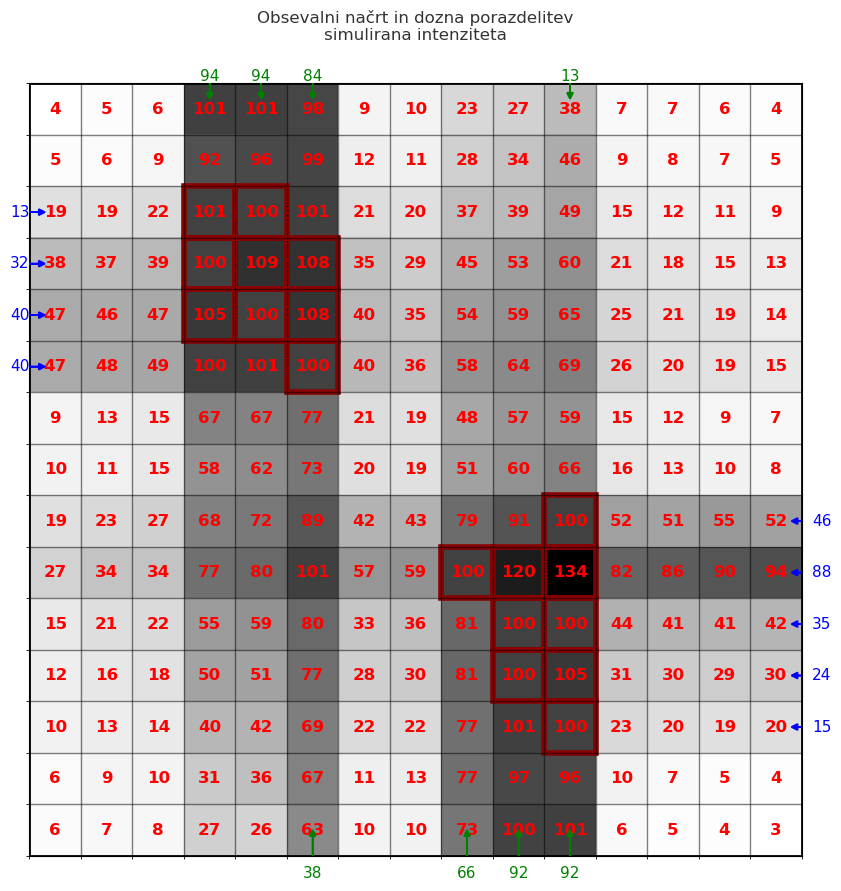

Statistics:
Average dose to tumor cells: 104.93
Average dose to healthy cells: 38.20
Ratio (tumor:healthy) = 2.75
Average dose to healthy tissue: 38.20
	End of optimization

--- Now testing Dmax_healthy = 104 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


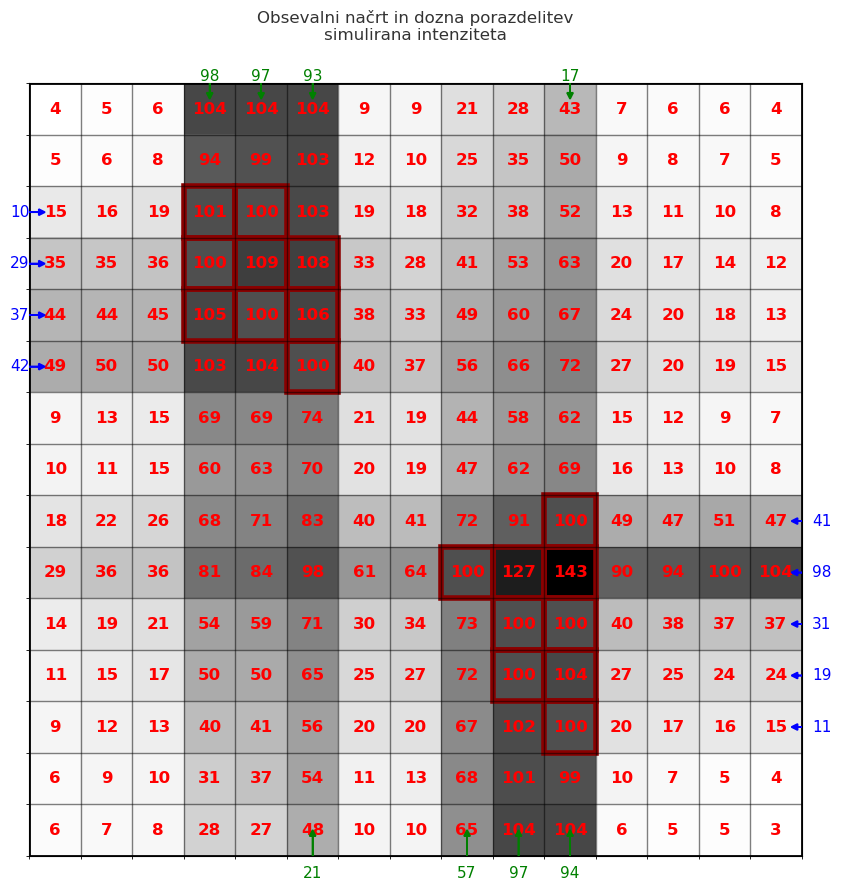

Statistics:
Average dose to tumor cells: 105.77
Average dose to healthy cells: 37.39
Ratio (tumor:healthy) = 2.83
Average dose to healthy tissue: 37.39
	End of optimization

--- Now testing Dmax_healthy = 107 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


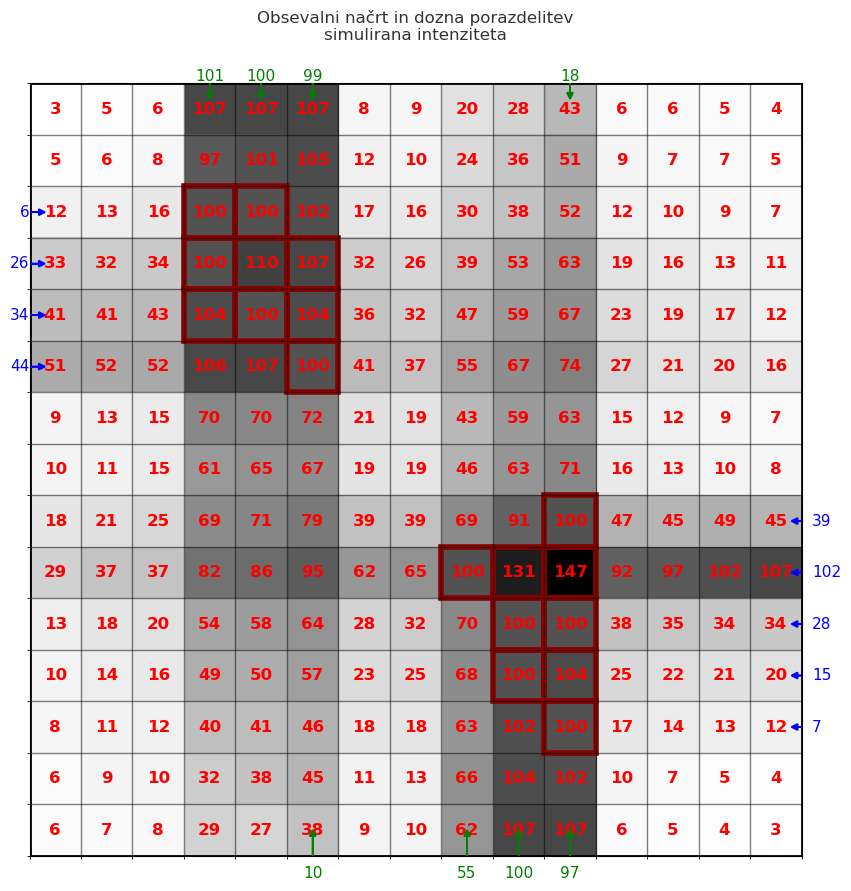

Statistics:
Average dose to tumor cells: 105.97
Average dose to healthy cells: 36.76
Ratio (tumor:healthy) = 2.88
Average dose to healthy tissue: 36.76
	End of optimization

--- Now testing Dmax_healthy = 110 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


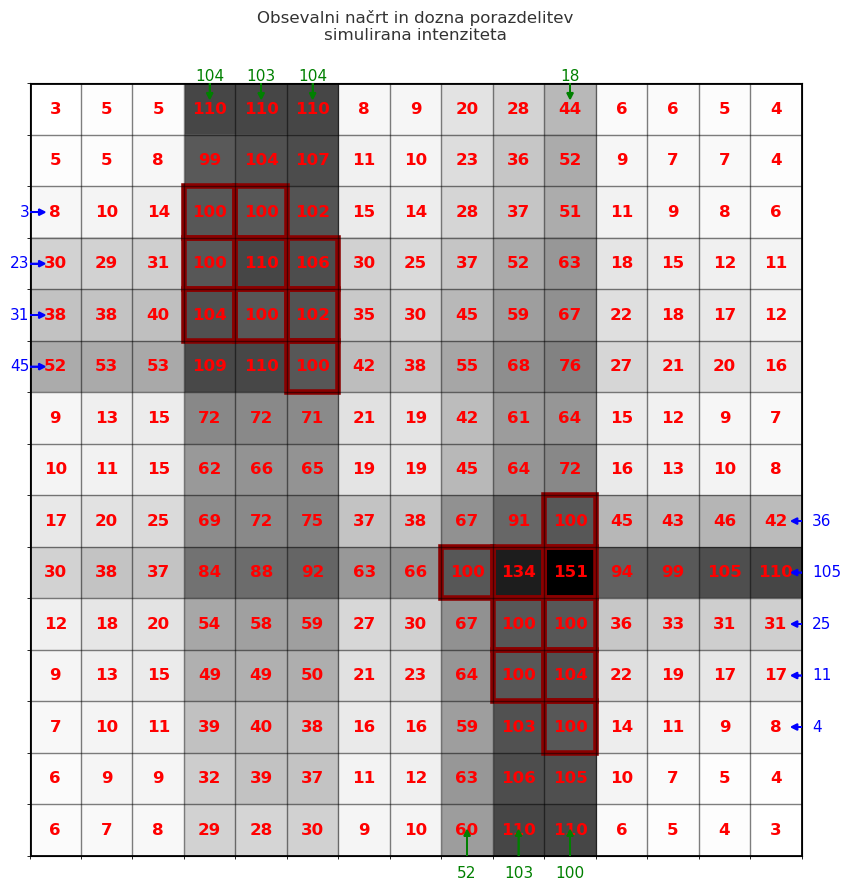

Statistics:
Average dose to tumor cells: 106.22
Average dose to healthy cells: 36.15
Ratio (tumor:healthy) = 2.94
Average dose to healthy tissue: 36.15
	End of optimization

--- Now testing Dmax_healthy = 115 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


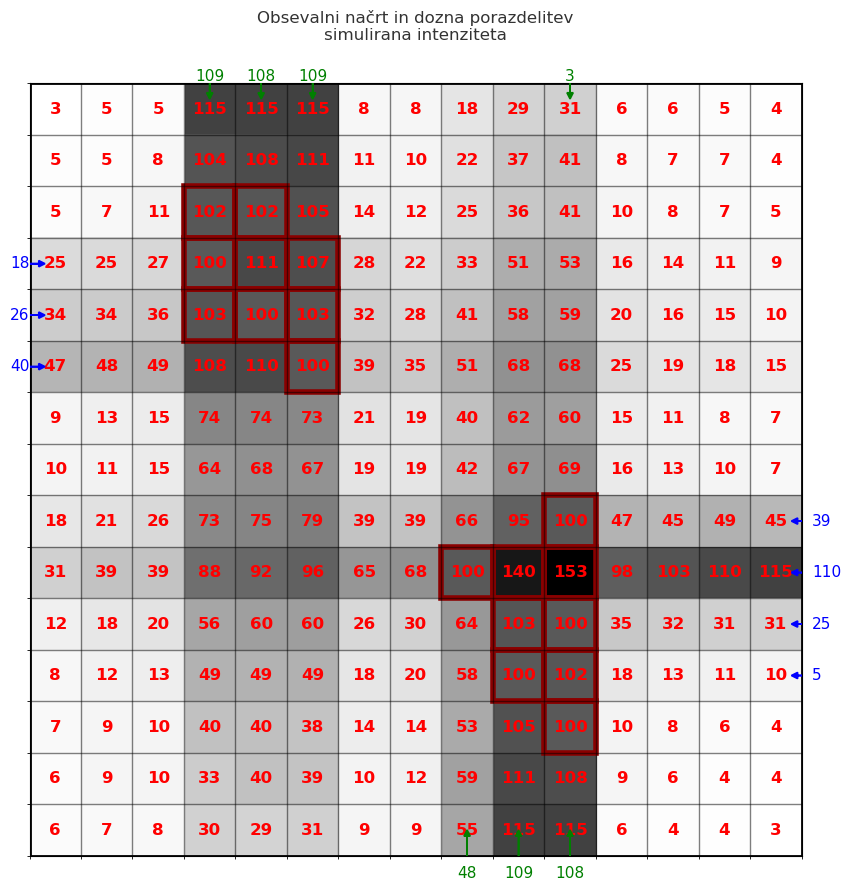

Statistics:
Average dose to tumor cells: 107.00
Average dose to healthy cells: 35.56
Ratio (tumor:healthy) = 3.01
Average dose to healthy tissue: 35.56
	End of optimization

--- Now testing Dmax_healthy = 120 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


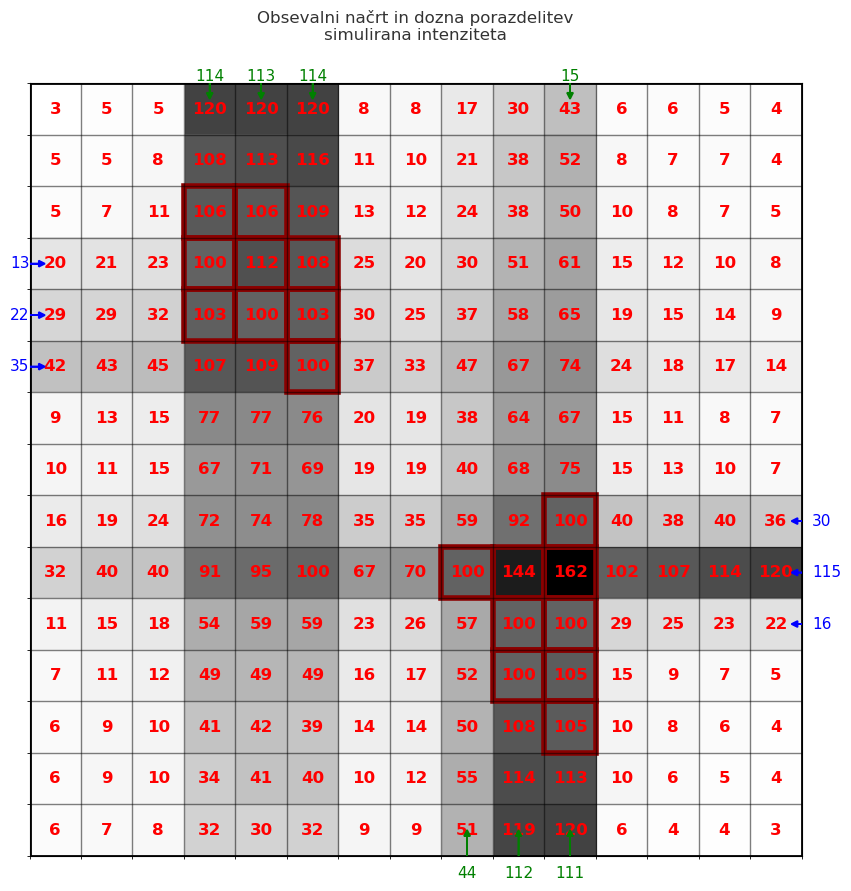

Statistics:
Average dose to tumor cells: 108.51
Average dose to healthy cells: 35.25
Ratio (tumor:healthy) = 3.08
Average dose to healthy tissue: 35.25
	End of optimization

--- Now testing Dmax_healthy = 130 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


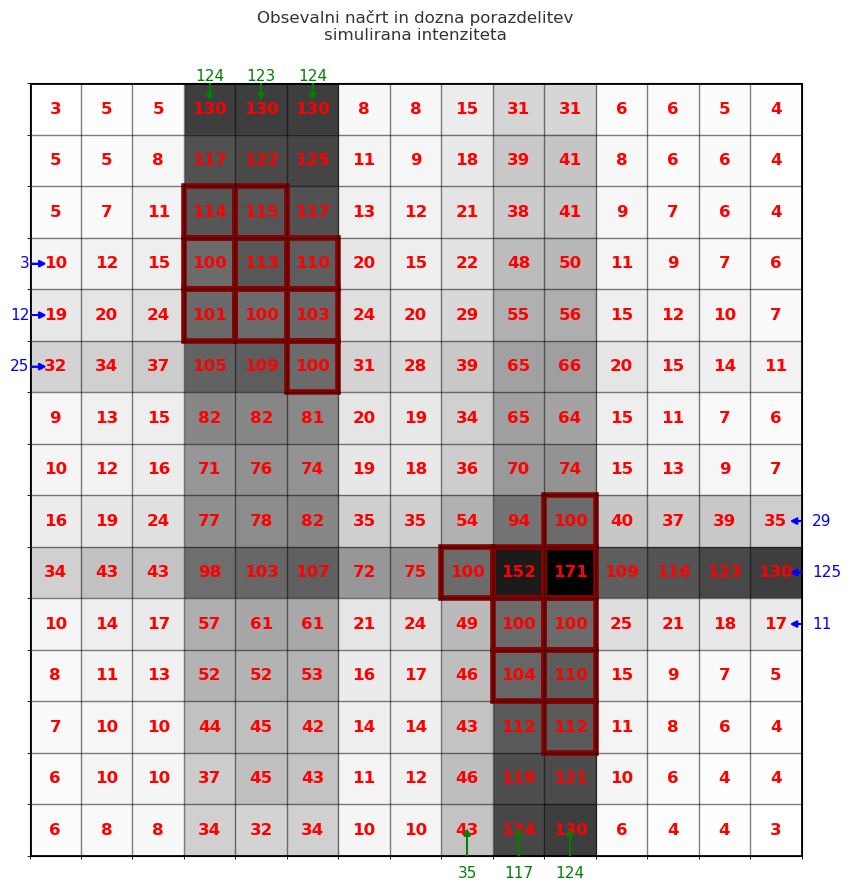

Statistics:
Average dose to tumor cells: 111.36
Average dose to healthy cells: 34.90
Ratio (tumor:healthy) = 3.19
Average dose to healthy tissue: 34.90
	End of optimization

--- Now testing Dmax_healthy = 140 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


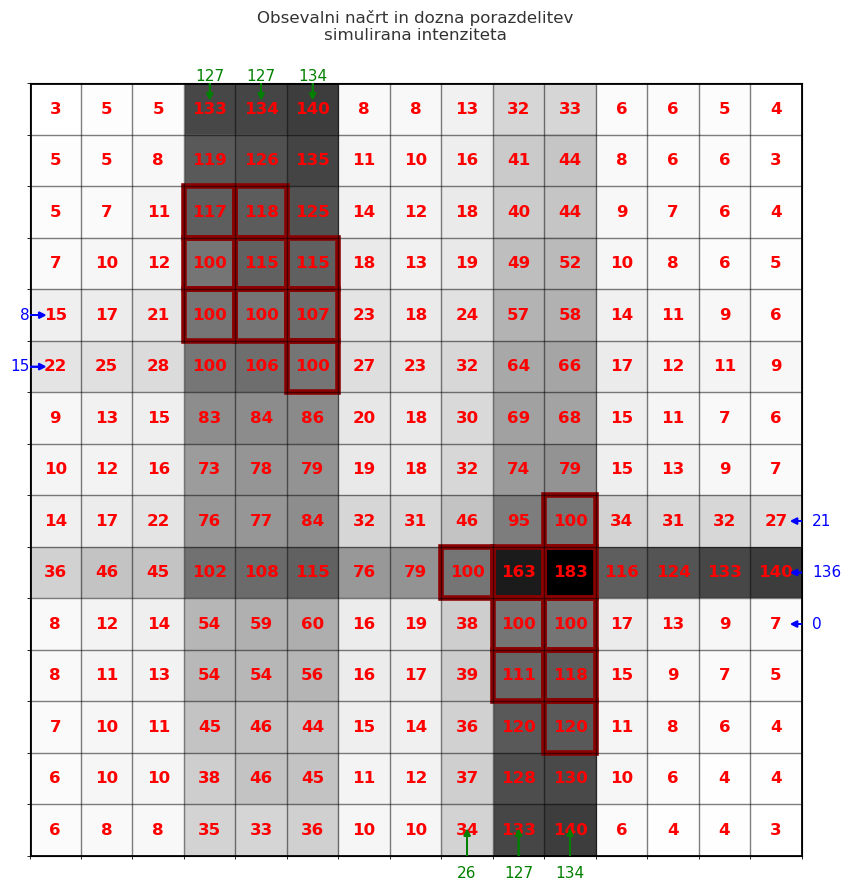

Statistics:
Average dose to tumor cells: 114.77
Average dose to healthy cells: 34.72
Ratio (tumor:healthy) = 3.31
Average dose to healthy tissue: 34.72
	End of optimization

--- Now testing Dmax_healthy = 160 ---
Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


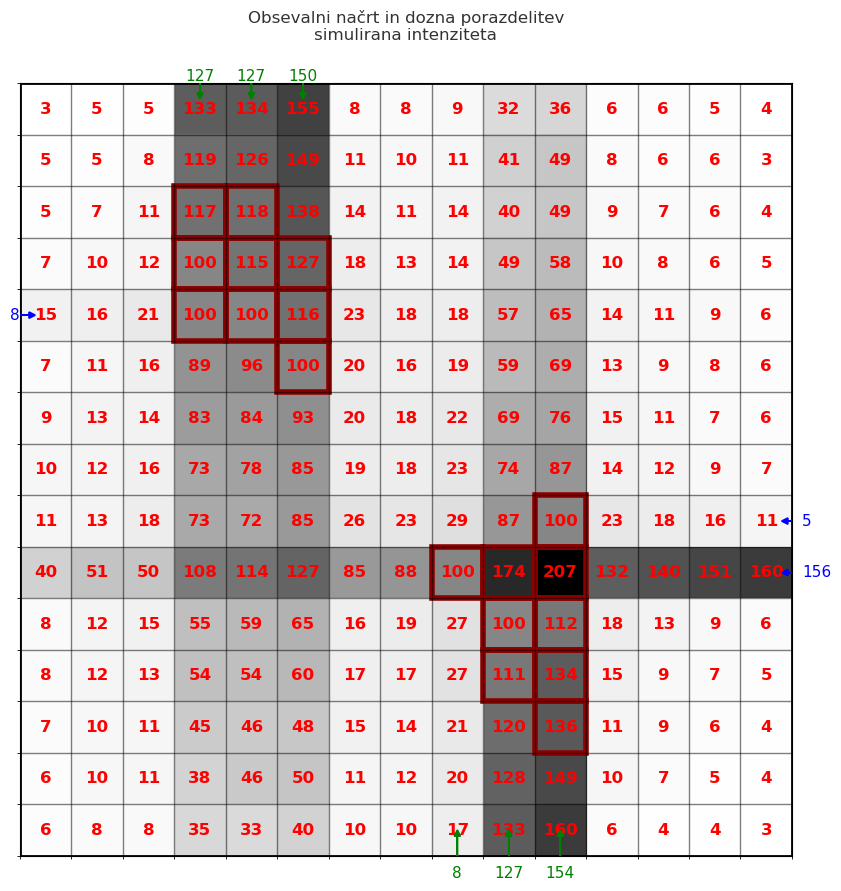

Statistics:
Average dose to tumor cells: 120.38
Average dose to healthy cells: 34.52
Ratio (tumor:healthy) = 3.49
Average dose to healthy tissue: 34.52
	End of optimization



In [279]:
importlib.reload(TissueIrradiationOptimizer)

Dmaxhealthy = [92,95,98,101,104,107,110,115,120,130,140,160]
Dmeanhealthy = []

# loop over maximum doses
for Dmax in Dmaxhealthy:
    print(f"--- Now testing Dmax_healthy = {Dmax} ---")
    MaxDoseHealthy = Dmax # maximum dose to healthy cells (optional, can be None, can cause optimization issues!)
    cell_dose_constr = {
        'min_dose_tumor': MinDoseTumor,
        'max_dose_healthy': MaxDoseHealthy
    }
    # prepare data for linear programming
    ProblemParameters = problem.prepare_data_for_linprog(
        cell_dose_constr,
        beam_type=beam_type, 
        lac=lac, 
        sim_irr_factors=SIF_data
        )
    optimizer = TissueIrradiationOptimizer.tissue_irradiation_optimizer(ProblemParameters)
    # run optimization
    optimizer.optimize()
    # calculate dose distribution
    TissueDoseDistribution = optimizer.tissue_dose_matrix
    # plot
    #problem.plot_tissue()
    #optimizer.plot_dose_distribution()
    optimizer.plot_irradiation_scheme()
    # calculate statistics
    optimizer.report_statistics()
    print(f"Average dose to healthy tissue: {optimizer.avg_dose_healthy:.2f}")
    Dmeanhealthy.append(optimizer.avg_dose_healthy)
    print("\tEnd of optimization\n")

# append for No dmaxhealthy restriction
Dmaxhealthy.append(169)
Dmeanhealthy.append(34.49)

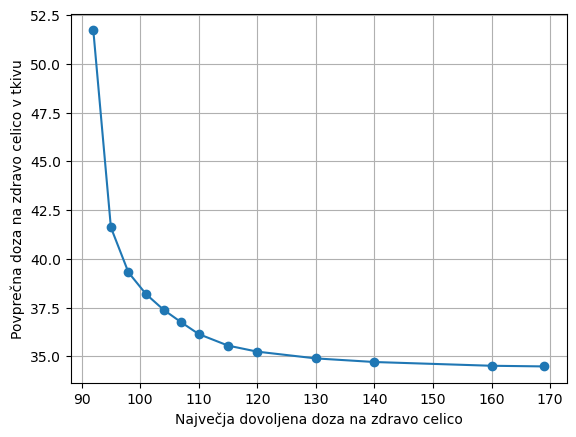

In [282]:

plt.plot(Dmaxhealthy, Dmeanhealthy, marker='o')
plt.xlabel('Največja dovoljena doza na zdravo celico')
plt.ylabel('Povprečna doza na zdravo celico v tkivu')
#plt.title('')
plt.grid()
plt.show()

Finish

---------------
-----------------
